In [1]:
import random 
random.seed(123)

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import sklearn.metrics as skm
from sklearn.model_selection import train_test_split
import operator as op

from sklearn.impute import SimpleImputer

import seaborn as sns
sns.set(rc={'figure.figsize': (12,8)})

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt


# 1. Data Importing

In [2]:
df = pd.read_csv('/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt',sep=";")
df.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [4]:
# Count the number of null values
df.isnull().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [5]:
df.isnull().any(axis = 1).sum()

25979

In [6]:
m, n = df.shape
df_per = (df.isnull().sum().sum())/m
col_pers = {}
for i in df.columns:
    col_pers[i] = (df[i].isnull().sum())/m

print(df_per)
print(col_pers)

0.012518437457686004
{'Date': 0.0, 'Time': 0.0, 'Global_active_power': 0.0, 'Global_reactive_power': 0.0, 'Voltage': 0.0, 'Global_intensity': 0.0, 'Sub_metering_1': 0.0, 'Sub_metering_2': 0.0, 'Sub_metering_3': 0.012518437457686004}


# 2. Data Pre-Processing

In [7]:
# Feature Modification
df['Date'] = df['Date'].astype(str)
df['Time'] = df['Time'].astype(str)
df.replace(['?', 'nan', np.nan], -1, inplace=True) 
num_vars= ['Global_active_power', 'Global_reactive_power', 'Voltage', 
           'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
for i in num_vars:
    df[i] = pd.to_numeric(df[i])
imp = SimpleImputer(missing_values=-1, strategy='mean')
df[num_vars] = imp.fit_transform(df[num_vars])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    float64
 3   Global_reactive_power  float64
 4   Voltage                float64
 5   Global_intensity       float64
 6   Sub_metering_1         float64
 7   Sub_metering_2         float64
 8   Sub_metering_3         float64
dtypes: float64(7), object(2)
memory usage: 142.5+ MB


In [8]:
# Target Variable
eq1 = (df['Global_active_power']*1000/60) 
eq2 = df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3']
df['power_consumption'] = eq1 - eq2
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,power_consumption
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


# Exploratory Data Analysis

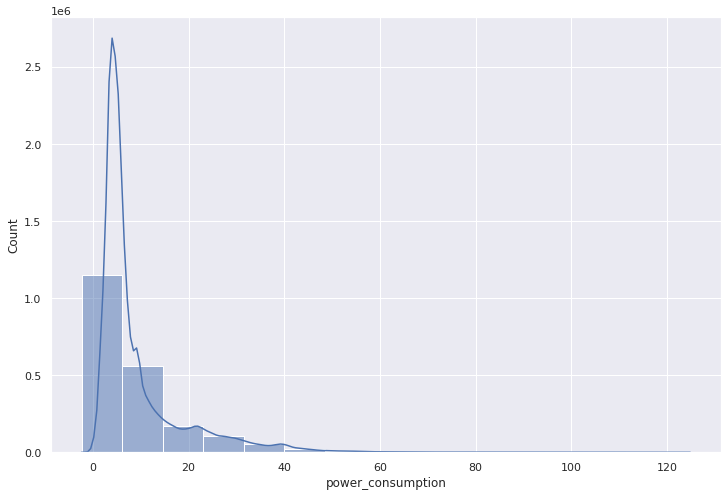

In [9]:
# Distribution of the target variables
sns.histplot(data=df, x='power_consumption', bins=15, kde=True)
plt.show()

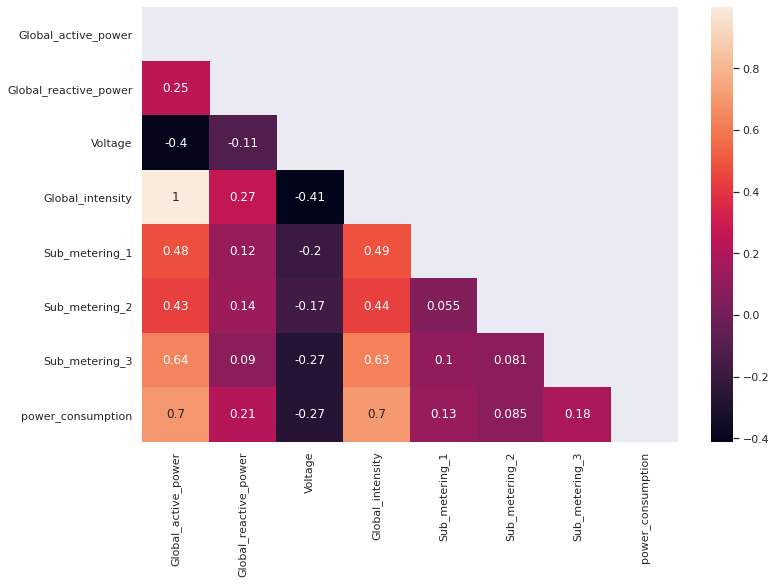

In [10]:
corr = np.corrcoef(df.corr())
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.corr(), annot=True, mask=mask)
plt.show()

# Model Building & Evaluation

In [11]:
models = {}
df1 = df
df1.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,power_consumption
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


## 1. Multiple Linear Regression

In [12]:
class linmodel():
    def __init__(self, df, target):
        self.df = df
        self.target = target

    def pre_processing(self):
        cat = ['Date', 'Time', 'power_consumption']
        X = self.df.drop(cat+[self.target], axis=1).values
        Y = self.df[self.target].values

        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(X, Y, 
                                                            test_size = 0.2, 
                                                            random_state = 2)
        return self

    def fit_pred_acc(self):
        reg = LinearRegression()
        reg.fit(self.X_train, self.Y_train)
        pred = reg.predict(self.X_test)
        mae = round(skm.mean_absolute_error(self.Y_test, pred), 2)
        rmse = round(skm.mean_squared_error(self.Y_test, pred, squared=False), 2)
        r2_score = round(skm.r2_score(self.Y_test, pred), 4)
        ev = round(skm.explained_variance_score(self.Y_test, pred), 4)
    
        return [mae, rmse, r2_score, ev]
    
lin = linmodel(df, 'Global_active_power')
lin = lin.pre_processing()
models["Mult. Reg"] = lin.fit_pred_acc()

## 2. Shrinkage Technique: Ridge

In [13]:
class rdgmodel():
    def __init__(self, df, target):
        self.df = df
        self.target = target

    def pre_processing(self):
        cat = ['Date', 'Time', 'power_consumption']
        X = self.df.drop(cat+[self.target], axis=1).values
        Y = self.df[self.target].values
        
        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(X, Y, 
                                                            test_size = 0.2, 
                                                            random_state = 2)
        return self

    def fit_pred_acc(self):
        reg = Ridge(alpha=0.0001, normalize=True)
        reg.fit(self.X_train, self.Y_train)
        pred = reg.predict(self.X_test)
        mae = round(skm.mean_absolute_error(self.Y_test, pred), 2)
        rmse = round(skm.mean_squared_error(self.Y_test, pred, squared=False), 2)
        r2_score = round(skm.r2_score(self.Y_test, pred), 4)
        ev = round(skm.explained_variance_score(self.Y_test, pred), 4)
    
        return [mae, rmse, r2_score, ev]
    
rdg = rdgmodel(df, 'Global_active_power')
rdg = rdg.pre_processing()
models["Ridge Reg"] = rdg.fit_pred_acc()

## 3. Shrinkage Technique: Lasso

In [14]:
class lasmodel():
    def __init__(self, df, target):
        self.df = df
        self.target = target

    def pre_processing(self):
        cat = ['Date', 'Time', 'power_consumption']
        X = self.df.drop(cat+[self.target], axis=1).values
        Y = self.df[self.target].values

        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(X, Y, 
                                                            test_size = 0.3, 
                                                            random_state = 72)
        return self

    def fit_pred_acc(self):
        reg = Lasso()
        reg.fit(self.X_train, self.Y_train)
        pred = reg.predict(self.X_test)
        mae = round(skm.mean_absolute_error(self.Y_test, pred), 2)
        rmse = round(skm.mean_squared_error(self.Y_test, pred, squared=False), 2)
        r2_score = round(skm.r2_score(self.Y_test, pred), 4)
        ev = round(skm.explained_variance_score(self.Y_test, pred), 4)
    
        return [mae, rmse, r2_score, ev]
    
las = lasmodel(df, 'Global_active_power')
las = las.pre_processing()
models["Lasso Reg"] = las.fit_pred_acc()

## 4. Polynomial Multiple Regression

In [15]:
class polymodel():
    def __init__(self, df, target):
        self.df = df
        self.target = target

    def pre_processing(self):
        cat = ['Date', 'Time', 'power_consumption']
        X = self.df.drop(cat+[self.target], axis=1).values
        Y = self.df[self.target].values

        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(X, Y, 
                                                            test_size = 0.2, 
                                                            random_state = 42)
        return self

    def fit_pred_acc(self):
        reg = LinearRegression(normalize=True)
        pol_feat = PolynomialFeatures(2)
        X_train_transf = pol_feat.fit_transform(self.X_train)
        X_test_transf = pol_feat.fit_transform(self.X_test)
        model = reg.fit(X_train_transf, self.Y_train)
        pred = model.predict(X_test_transf)
        mae = round(skm.mean_absolute_error(self.Y_test, pred), 2)
        rmse = round(skm.mean_squared_error(self.Y_test, pred, squared=False), 2)
        r2_score = round(skm.r2_score(self.Y_test, pred), 4)
        ev = round(skm.explained_variance_score(self.Y_test, pred), 4)
    
        return [mae, rmse, r2_score, ev]
    
poly = polymodel(df, 'Global_active_power')
poly = poly.pre_processing()
models["Poly Reg"] = poly.fit_pred_acc()

In [16]:
models_df = pd.DataFrame.from_dict(models, orient='index',
                  columns=['MAE', 'RMSE', 'R_sq', 'Expl. Var.'])
models_df

,MAE,RMSE,R_sq,Expl. Var.
Mult. Reg,0.03,0.04,0.9985,0.9985
Ridge Reg,0.03,0.04,0.9985,0.9985
Lasso Reg,0.17,0.23,0.9509,0.9509
Poly Reg,0.02,0.04,0.9988,0.9988
